<a href="https://colab.research.google.com/github/lucashofer/atomcloud/blob/main/docs/notebooks/Sum_Fits.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Sum-Fit

2D SumFits allow us to perform simulataneous 1D fits on the 2D data summed along the x and y axes. These 1D fits are then used to construct a 2D seed for a full 2D fit.

This notebook will walk through the process of using a 2D SumFit. However, we
recommend first going through the Multi-Function and Multi-Function Fit notebooks as these give the neccessary background.

First let's install AtomCloud and JAXFit (for GPU acceleration).

In [1]:
!pip install jaxfit
!pip install atomcloud

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 69.5/69.5 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.4/98.4 kB 11.4 MB/s eta 0:00:00


Let's get some example data of a bimodal distribution and plot the data

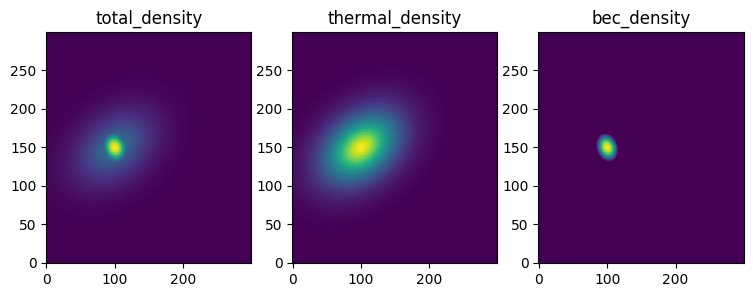

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from atomcloud import example_data

XY_tuple, densities, parameters = example_data.get_example_data()
total_density, thermal_density, bec_density, offset = densities

labels = ['total_density', 'thermal_density', 'bec_density']

fig, axes = plt.subplots(1, 3, figsize = (9, 3))

for ax, density, label in zip(axes, densities, labels):
    ax.pcolormesh(*XY_tuple, density,shading='auto')
    ax.set_title(label)

## 1D MultiFunction Fits

Now for simplicity, let's start by looking at 1D fits. We'll first use some of AtomCloud's built in functions to take the 2D data and sum it along both the x and y axes.

Text(0.5, 1.0, 'ysum')

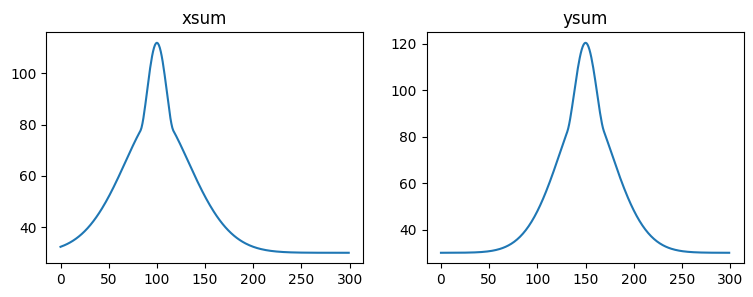

In [3]:
from atomcloud.utils import img_data_to_sums

x, y, xsum, ysum = img_data_to_sums(XY_tuple, total_density)

fig, axes = plt.subplots(1, 2, figsize = (9, 3))

axes[0].plot(x, xsum)
axes[0].set_title('xsum')

axes[1].plot(y, ysum)
axes[1].set_title('ysum')

Now in the multi-function notebook we saw how to create a multi-function object
for both 1d and 2d fits. We also used the results from the 1d fit along a single axis to create a seed for the 2d fit.

However, it is much more robust to perform a 1d fit along both axes and use the results from both fits to create a seed for the 2d fit. This is what the 2d SumFit does.

Now let's try it out with a Gaussian. Internally, the SumFit will perform two MultiFit1D fits. Thus, the parameters for intantiating a SumFit are the same as for a MultiFit1D.

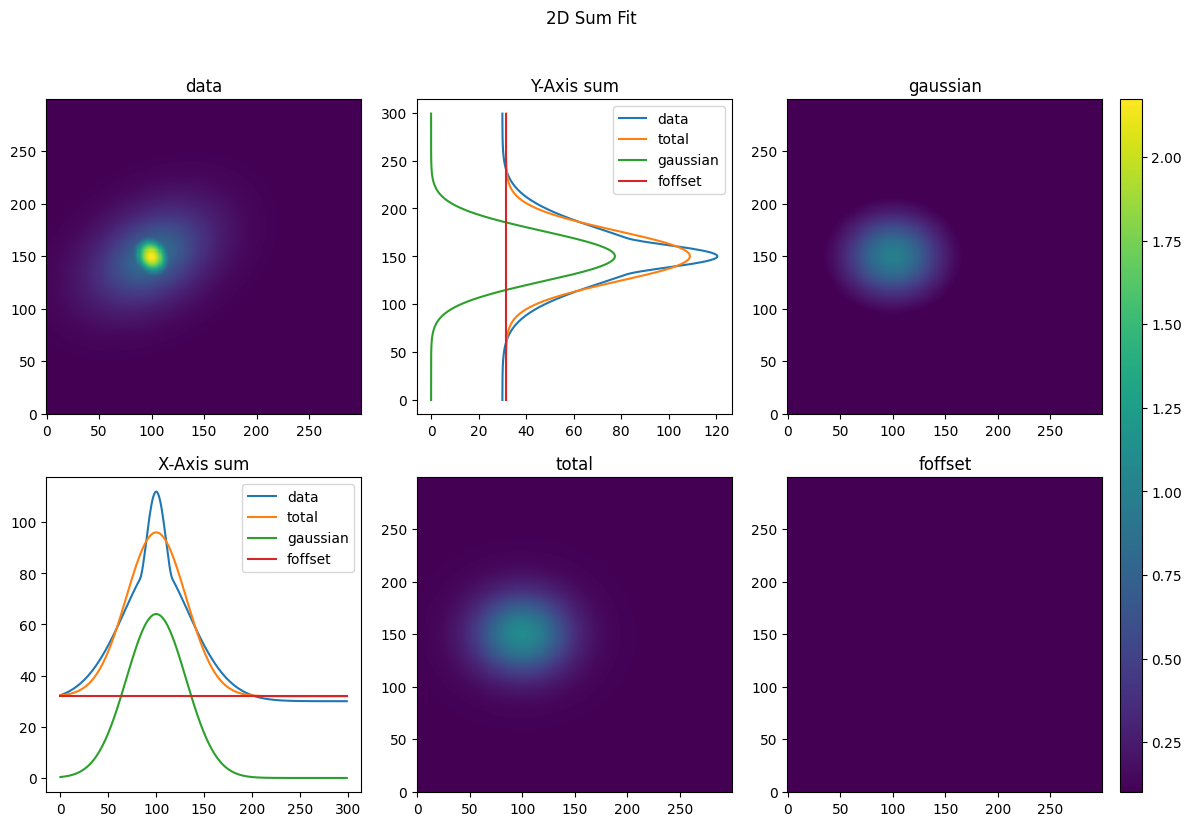

2d
{'fit_type': 'cloud2d', 'equations': ['gaussian', 'foffset'], 'constraints': None, 'params': [[0.98198251689203, 99.9980948247536, 150.11323702435925, 31.092586018452234, 26.3128942194796, 0], [0.10577817870563223]], 'data_sum': 14566.38403734596}
--------------------
xsum
{'fit_type': '1d', 'equations': ['gaussian', 'foffset'], 'constraints': None, 'params': [[64.07580437020107, 31.092586018452234, 99.9980948247536], [31.918460219430933]], 'fit_metrics': {'chi_squared': 5766.650373726157, 'chi_squared_red': 19.351175750758916}, 'data_sum': 14566.384037345959}
--------------------
ysum
{'fit_type': '1d', 'equations': ['gaussian', 'foffset'], 'constraints': None, 'params': [[77.35156972963038, 26.3128942194796, 150.11323702435925], [31.548447003948407]], 'fit_metrics': {'chi_squared': 4002.643125909777, 'chi_squared_red': 13.431688341979118}, 'data_sum': 14566.38403734596}
--------------------


In [4]:
from atomcloud.fits import SumFit2D
from atomcloud.process_fits import plot_fitdict

gauss_eqs = ['gaussian', 'foffset']

gauss_sfit_obj = SumFit2D(gauss_eqs)
params, gauss_sfit_dict = gauss_sfit_obj.get_fit(XY_tuple, total_density)

plot_fitdict(gauss_sfit_dict, XY_tuple, total_density)

for key, item in gauss_sfit_dict.items():
    print(key)
    print(item)
    print('-'*20)

Note that the fitdict is now a dictionary of dictionaries. The top level dictionary contains the dictionary for the fit along the x axis, the y axis and the constructed 2d seed.

The plot from this fit looks similar to a 2D fit; however since the 2D distributions are reconstructed from the 1D sums they don't have any information about the angle of the distribution---which can be clearly seen in the plot.

We can also use the results from this fit to seed a more complicated SumFit. Let's try a SumFit with a Gaussian and a Thomas-Fermi distribution.

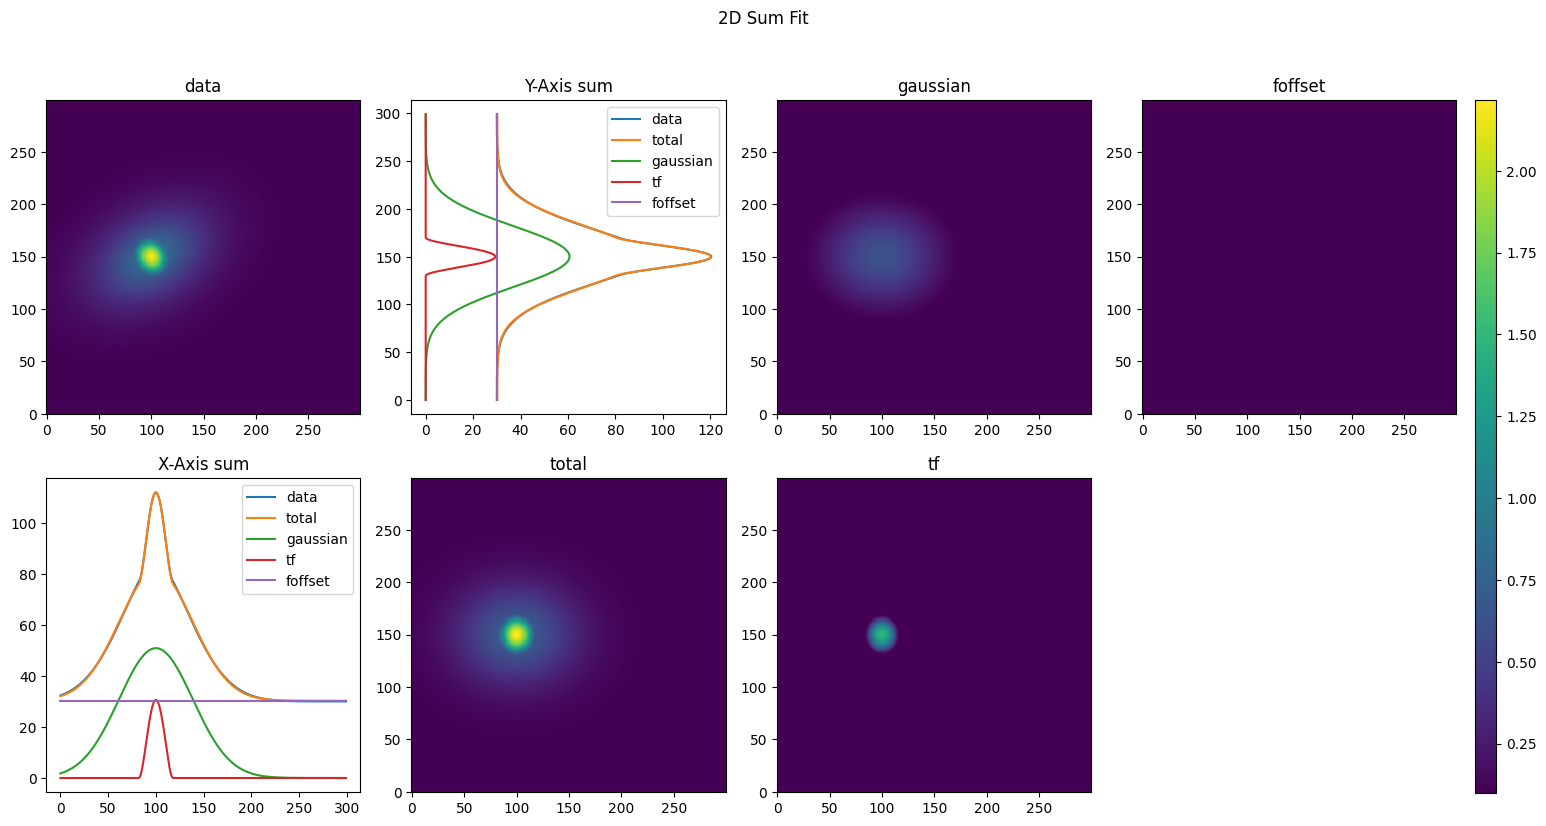

In [5]:
from atomcloud.utils import fit_utils

#create the bimodal sumfit 1d seed
x_gauss_params, x_offset_params = gauss_sfit_dict['xsum']['params']
y_gauss_params, y_offset_params = gauss_sfit_dict['ysum']['params']

x_tf_params = x_gauss_params.copy()
x_tf_params[1] /=2

y_tf_params = y_gauss_params.copy()
y_tf_params[1] /= 2

x_bimodal_seed = [x_gauss_params, x_tf_params, x_offset_params]
y_bimodal_seed = [y_gauss_params, y_tf_params, y_offset_params]
bimodal_seed1d = [x_bimodal_seed, y_bimodal_seed]

#fit the bimodal sumfit
bimodal_eqs = ['gaussian', 'tf', 'foffset']
bimodal_sfit_obj = SumFit2D(bimodal_eqs)
params, bimodal_sfit_dict1d = bimodal_sfit_obj.get_fit(XY_tuple,
                                                     total_density,
                                                     seed=bimodal_seed1d)

plot_fitdict(bimodal_sfit_dict1d, XY_tuple, total_density)

Alternatively you can seed SumFit with 2D seeds, because it's versatile.

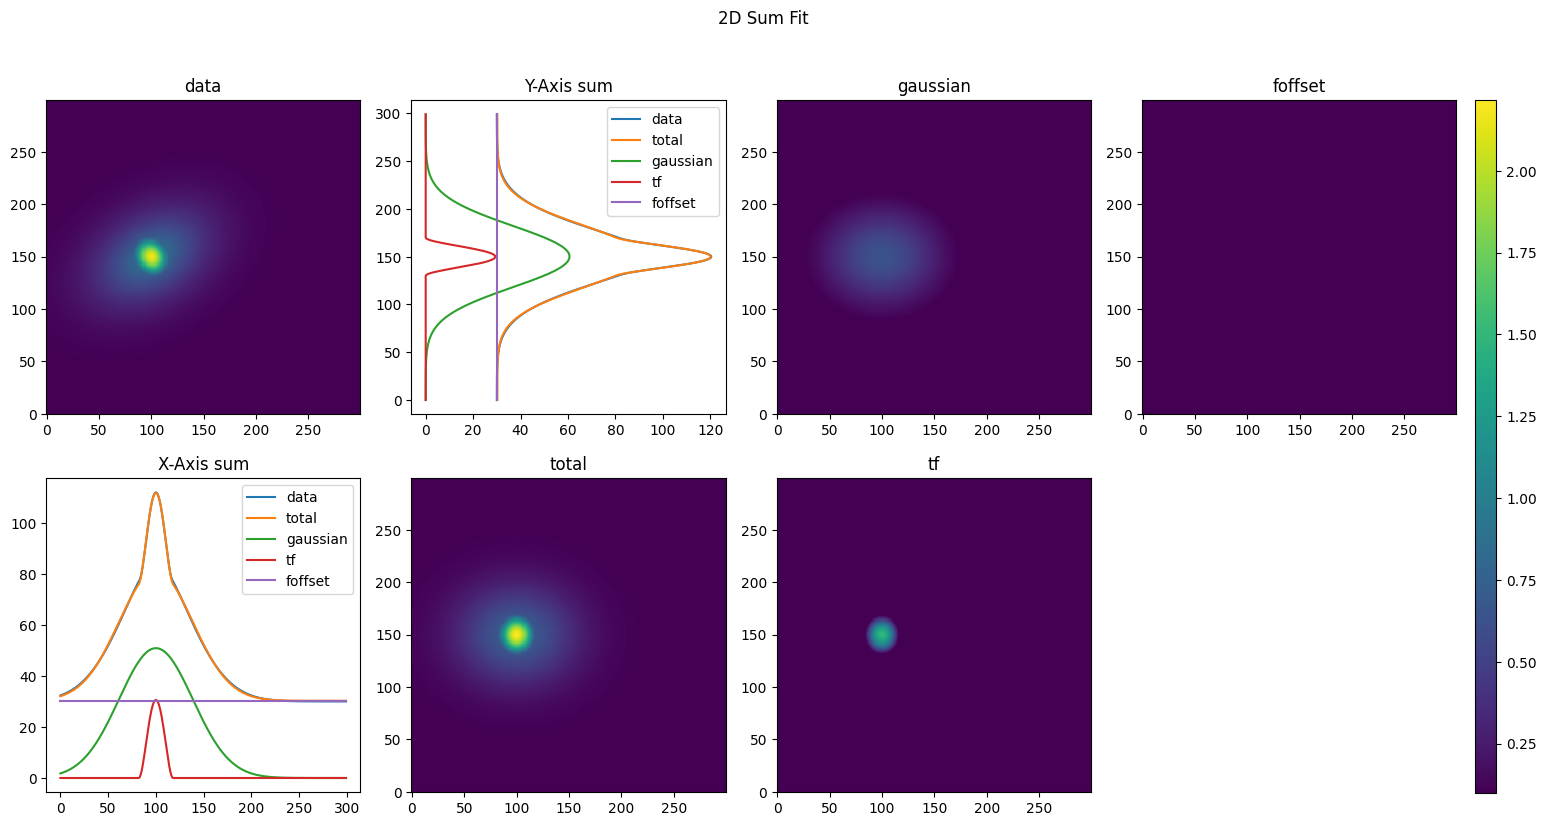

In [6]:
from atomcloud.utils import fit_utils

#create the bimodal sumfit seed
gauss_params2d, offset_params2d = gauss_sfit_dict['2d']['params']
tf_params2d = gauss_params2d.copy()
tf_params2d[3] /= 2
tf_params2d[4] /= 2

bimodal_seed2d = [gauss_params2d, tf_params2d, offset_params2d]

params, bimodal_sfit_dict2d = bimodal_sfit_obj.get_fit(XY_tuple,
                                                     total_density,
                                                     seed = bimodal_seed2d)

plot_fitdict(bimodal_sfit_dict2d, XY_tuple, total_density)

Now the real benefit of the SumFit is that it can be easily used to seed a 2D fit. Let's use these
results to seed a 2D bimoal fit.

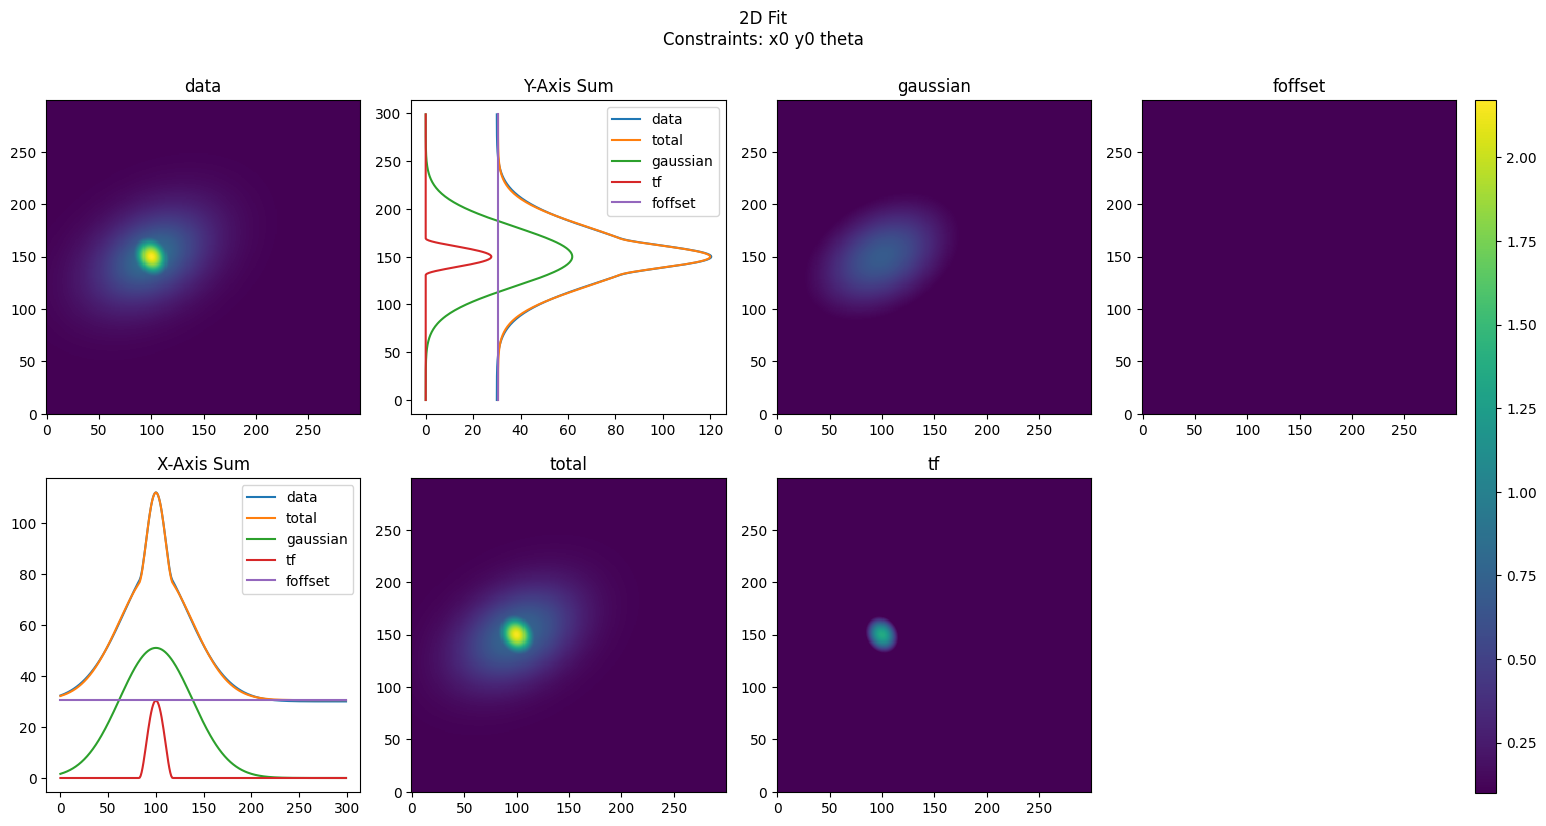

In [7]:
from atomcloud.fits import MultiFit2D

bimodal_seed_2d = bimodal_sfit_dict2d['2d']['params']

#construct the 2d bimodal fitting object
bimodal2d_eqs = ['gaussian', 'tf', 'foffset']
bimodal2d_constraints = ['x0', 'y0', 'theta']
bimodal2d_fit_obj = MultiFit2D(bimodal2d_eqs, bimodal2d_constraints)

#do the fit
params, bimodal2d_fit_dict = bimodal2d_fit_obj.get_fit(XY_tuple, total_density,
                                                       bimodal_seed_2d)
#plot the fit
plot_fitdict(bimodal2d_fit_dict, XY_tuple, total_density)

This process of using the SumFit to seed a 2D fit is very handy when doing
multi-level fits

## Custom SumFit Functions

Similar to how we were able to create custom 1D and 2D sub-functions for the
1D and 2D MultiFits, we can also create custom SumFit object.

If a user has a custom function they must define both a 1d func object for that function and add it to the 1d function registry.

Next the user must define a sumfunction object (with the same name as the 1D function) and add it to the sumfunction registry. The sumfunction object is used to convert between the 1D fit parameters and the 2D fit parameters.

To create the sumfunction object. The user should inherit from the SumFitBaseFunc class and define the convert_2d_sum and convert_sum_2D which converte between 1D sums and 2D fits. The user should then add the sumfunction to the SUMFUNCTIONS registry with a key. This function can then be called using the sumfit object.

An example of this is shown below.

In [8]:
from atomcloud.functions import SumFitBaseFunc, SUMFUNCTIONS
from atomcloud.functions import amps_2D_to_1D, amps_1D_to_2D

class Lorentz(SumFitBaseFunc):

    def convert_2d_sum(self, XY_tuple, params):
        amp2d, x0, y0, sigmax, sigmay, theta = params
        amps1d = amps_2D_to_1D(amp2d, sigmax, sigmay, self.gaussian1D_amp)
        xsum_amp, ysum_amp = amps1d
        return [xsum_amp, sigmax, x0], [ysum_amp, sigmay, y0]

    def convert_sum_2D(self, XY_tuple, xparams, yparams):
        ax, sigmax, x0 = xparams
        ay, sigmay, y0 = yparams
        amp = amps_1D_to_2D(ax, ay, sigmax, sigmay, self.gaussian1D_amp)
        return [amp, x0, y0, sigmax, sigmay, 0]

SUMFUNCTIONS.register('lorentz', Lorentz)